In [1]:
# code adapted from https://github.com/eriklindernoren/PyTorch-GAN
%cd

/home/kacper


In [2]:
from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image

cuda = True if torch.cuda.is_available() else False


class Options:
    def __init__(self):
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 64
        self.channels = 3
        self.sample_interval = 400

opt = Options()

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [13]:
from DeepLearning.Project3.frechet_metric import generate_images_to_path
for epoch_number in range(0, 140, 10):
    for i in range(10):
        for j in range(10):
            generate_images_to_path(
                torch.load(f"experiments_gan/cdgan_generator_epoch_{epoch_number}.pt"),
                path = f"images/cdgan_exp/{epoch_number}/fid/{i}/{j}/",
                batch_size = 200,
                latent_size = 100,
                img_size = 64
            )

In [14]:
results = []
from DeepLearning.Project3.frechet_metric import fid_metric

for images_path, epoch_number in [(f"images/cdgan_exp/{epoch_number}/fid/", epoch_number) for epoch_number in range(0, 140, 10)]:
    fid = fid_metric('.data/data0/lsun/bedroom/0', images_path)
    results.append({
        "epoch": epoch_number,
        "fid": fid
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:13<00:00,  4.24it/s]


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

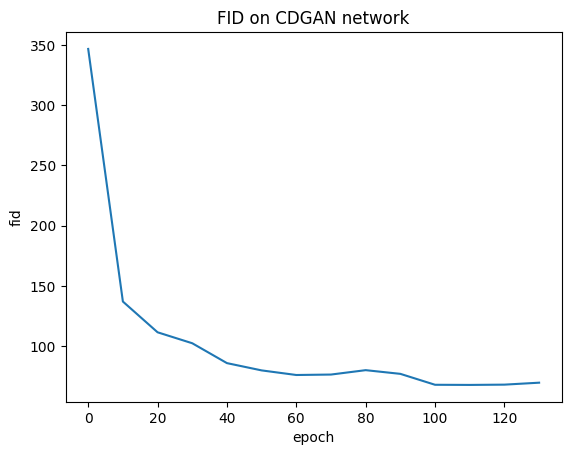

In [16]:
sns.lineplot(pd.DataFrame(results), x="epoch", y="fid")
plt.title("FID on CDGAN network")
plt.show()